## **0. What is `cbeam`?**

`cbeam` ("coupled-beam") simulates the propagation of guided wavefronts through slowly-varying, few-noded waveguides using coupled-mode theory. The waveguide mode profiles, required for this approach, are solved for using the finite element method. When applicable, coupled-mode propagation is faster than alternate techniques like the finite difference beam propagation method (FD-BPM). `cbeam` is mostly written in Python, and has a completely Pythonic interface, with some parts written in Julia. In this notebook, we'll go over installation instructions, provide basic documentation, and give some starting examples.

## **Table of Contents**
1. [Installation and background](#sec1)
    1. [How to install](#sec1.1)
    2. [Limitations](#sec1.2)
2. [Basic usage](#sec2)
    1. [Defining waveguides](#sec2.1)
    2. [Propagation](#sec2.2)
3. [Advanced usage](#sec3)
    1. [Mesh generation](#sec3.1)
    2. [Adaptive $z$ stepping](#sec3.2)
    3. [Handling mode degeneracy](#sec3.3)
    4. [Mesh transformation and remeshing](#sec3.4)
    5. [Accessing eigenvalues, modes, and more](#sec3.5)
    6. [Propagation parameters](#sec3.6)
    7. [Evaluation of FE fields](#sec3.7)
4. [Example: photonic lantern](#sec4)
5. [Example: directional coupler](#sec5)

<a id='sec1'></a>
## **1. Installation and background**
<a id='sec1.1'></a>
#### **1.1 How to install**
Right now, `cbeam` is not packaged (though it will be in the future). For now,  install by cloning the Github repo. You will need both a Python3 and a <a href="https://julialang.org/downloads/">Julia</a> installation. Below are the following dependencies:

**General**: `Gmsh` (download <a href="https://gmsh.info/">here</a>)

**Python**: `numpy`,`scipy`,`juliacall`,`wavesolve`,`pygmsh`,`meshio`,`matplotlib` <br> (All `pip` installable besides `wavesolve`, download <a href="https://github.com/jw-lin/wavesolve">here</a>)

**Julia**: `PythonCall`, `StaticArrays`, `GrundmannMoeller` <br>
To install the Julia packages, after cloning `cbeam`, start a Julia REPL in the root directory and run the following:

```
using Pkg
Pkg.activate("FEval")
Pkg.add("PythonCall")
Pkg.add("StaticArrays")
Pkg.add("GrundmannMoeller")
exit()
```

When updating, if a change has been made to the Julia source code, you will have to re-run the above (and most likely delete the auto-generated `Manifest.toml` file and `.CondaPkg` folder in the `FEval` directory beforehand, if they exist.)

<a id='sec1.2'></a>

#### **1.3 Limitations and known issues**

**Limitations**

1. **Only waveguides with step-index profiles are currently supported**.
2. **Finite element meshes corresponding to these waveguides must evolve forward in z continiously.** This is potentially restricts the types of waveguides that can be simulated.

**Known issues**

It's anecdotally clear that certain mesh geometries (for the same waveguide) lead to fast computations, while other geometries will be much slower. As of now there is no way of telling whether a mesh is "good" or "bad", other than by explicitly running the propagator. Ideas welcome on how to improve.

The code seems is a work in progress, so expect bugs. Comparisons with `lightbeam` are overall consistent, although there is occasionally a few % difference in the mode powers predicted by `lightbeam` and `cbeam`. This error appears to go down as the $z$-variation of the waveguide becomes slower.

<a id='sec2'></a>
## **2. Basic usage**

`cbeam` provides the following modules.

> `waveguide` : one of two main modules, used to define waveguides.

> `propagator` : the second main module, used to define propagation parameters and run propagations.

The typical workflow is to first define a waveguide using the first module, and the model waveguide propagation with the second module.

<a id='sec2.1'></a>
### **2.1 Defining waveguides**

In this section we discuss how to build waveguides from the bottom-up. In practice, users may only need to interact with the high-level `Waveguide` class covered in Section 2.1.3.

<a id='sec2.1.1'></a>
#### **2.1.1 the `Prim2D` class**

The most basic parent class that represents a refractive index geometry is a `Prim2D`. Each `Prim2D` stores a refractive index value and an array of $(x,y)$ points bounding the physical region which containts that index value. A `Prim2D` is generically initialized through

**`prim2D = waveguide.Prim2D(n,points)`**

**Arguments**

1.  `n` : the refractive index inside the region of the primitive. 

2. `points` (optional): an $N\times 2$ array of $(x,y)$ points corresponding to a material interface The first and last point are automatically connected. Default is `None`, since `points` can also be generated with a functional dependence, as mentioned next.  

To make specific types of geometries, users are encouraged to define subclasses that inherit from `Prim2D` and generate `points` according to specific rules. These subclasses should implement their own `make_points()` functions, which at minimum should take in some set of arguments (like radius, for a circle primitive) and return the corresponding point array. See the `Circle` and `Rectangle` classes for examples. 

More complicated primitives can be created through the `waveguide.Prim2DUnion` class, which inherits from `Prim2D`.

<a id='sec2.1.2'></a>
#### **2.1.2 the `Prim3D` class**

The next level in complexity is the `Prim3D` parent class, which combines a `Prim2D` with rules that define evolution with respect to $z$. A `Prim3D` is generically initialized as 

**`prim3D = waveguide.Prim2D(prim2D,label)`**

**Arguments**

1. `prim2D` : a `Prim2D` object representing the cross-section of the `Prim3D`
2. `label` : a user-specified identifying string to attach to the physical region bounded by `prim2D.points` (e.g. "core" or "cladding" for a step-index fiber.)

Like with `Prim2D`, users are encouraged to make their own `Prim3D` subclasses, which implement their desired $z$-dependence. Inheriting classes must implement the function `make_points_at_z()`, which updates `prim2D` to the desired $z$ coordinate and returns the `point` array. The two subclasses currently implemented are `Pipe`, which can be used to represent geometries where the cross-section remains circular at all $z$, and `Box`, which describes a `Rectangle` that does not change with $z$.

<a id='sec2.1.3'></a>
#### **2.1.3 the `Waveguide` class**

A `Waveguide` stores a (potentially nested) list of `Prim3D`s, which we will call `prim3Dgroups`. The refractive index profile of each top-level element in `prim3Dgroups` is overwritten by the immediate next element. Any element containing a list of `Prim3D`s is treated as a single `Prim3D`.* So, an optical fiber might store its primitives as `[cladding,core]`, where `cladding` and `core` are `Pipe`s corresponding to the cladding and core regions; a multicore fiber could have the structure `[cladding,[core1,core2,...]]`. A `Waveguide` is generically initialized as 

**`wvg = Waveguide(prim3Dgroups)`**

**Arguments** 

1.  `prim3Dgroups` : the potentially nested list of 3D primitives mentioned above.

All `Waveguide` objects have various predefined class functions for mesh generation; see Section 3.1 for more details. Like before, users are encouraged to define their own `Waveguide` subclasses, which should implement the following function:

> `transform(x0,y0,z0,z)` : this function takes a point $(x0,y0,z0)$ and returns a new point $(x,y)$ at the longitudinal coordinate $z$. This transformation is used give $z$ dependence to the mesh geometry in a continuous manner.

`Waveguide` objects come with several functions to create meshes for finite element analysis. The mesh generation can be tuned via `Waveguide` class attributes; see Section 3.1 for more details. For example `Waveguides`, check out the `PhotonicLantern` and `Dicoupler` classes. We run simulations of both in Section 4.

*`Prim3D` objects in the same sublist should never intersect. However, they can have different `label`s and refractive indices. If you want to construct an object formed from the union of two simpler objects, you should make a `Prim2DUnion`, and then apply some $z$-dependence to make a custom `Prim3D`.

### **2.2 Propagation - the `Propagator` class**

#### **2.2.1 initialization**

Below is the pattern for initialization: 

**`prop = propagator.Propagator(wl,wvg,Nmax,save_dir)`**

**Arguments**

1.  `wl` : the propagation wavelength (in the same spatial unit that the waveguide geometry is defined in)
2. `wvg` : a `Waveguide` object
3. `Nmax` : the number of propagating modes in this waveguide (we cannot at the moment treat radiative modes)
4. `save_dir` : the local path for where data should be saved. The default is `"./data"`. Folders will be created if they are not found.

#### **2.2.2 waveguide characterization**

Before we can apply coupled-mode theory to simulate the waveguide we have loaded, we need the following as a function of $z$:
* **the instanteous eigenmodes**
* **the instanteous eigenvalues**
* **the coupling coefficient matrix** (formed from the inner product of eigenmodes and eigenmode derivatives.)

This step takes the bulk of the time when it comes to waveguide simulation. To compute the above, we use `prop.prop_setup()`, which will generate a finite-element mesh for the given waveguide and adaptively step forward in $z$, calculating the required items. This function  The function signature is as follows:

**`prop.prop_setup(zi,zf,save,tag,plot)`**

**Arguments**

1. `zi` : the starting $z$ coordinate to compute the eigenmodes, eigenvalues, and cross-coupling matrix. Does not have to be 0.
2. `zf` : the ending $z$ coordinate, which does not have to be the maximum extent of the waveguide.
3. `save` : set to True to write all computation results to file. These can be loaded later with `prop.load(tag)`, where `tag` is the next arg.
4. `tag` : a string tag to attach to output files so that they can be loaded later.
5. `plot` : set true to plot the initial mesh and eigenmodes, good for sanity checking.

**Returns**
1. `za` : the array of $z$ values traversed by the adaptive stepping algorithm. Denote the length $M$.
2. `cmat` : for $N$ eigenmodes, this is the array of $N\times N$ cross-coupling matrices computed over `za`; overall dimension $M\times N\times N$.
3. `neff` : the array of mode effective indices computed over `za`; overall dimension $M\times N$.
4. `vs` : the array of eigenmodes computed over `za`. For $L$ mesh points, the overall dimension is $M\times N \times L$.

There are also a number of optional arguments related to the adaptive $z$-stepping scheme with are accessed through `Propagator` attributes; see Section 3.2


#### **2.2.3 propagation**

Once `prop_setup()` has been run, or files produced by a previous setup have been loaded with `prop.load(tag)`, we can simulate light propagation. The first step is to quickly generate interpolation functions for the eigenmodes, eigenvalues, and coupling coefficient matrix over $z$. This is done with:

**`prop.make_interp_funcs()`**

This function will create interpolation functions that allow us to compute the cross-coupling matrix, eigenmodes, eigenvalues, and eigevalue derivative/antiderivatives, as a function of $z$, which will be used later to solve the coupled-mode equations. 

From here, we can define a launch field, expressed in the basis of the initial eigenmodes of the waveguide, e.g. 

**`u0 = [1,0,0,...]`** (launching in the first mode)

and the propagate the field using `prop.propagate()`. The pattern is as follows:

**`z,u,uf = prop.propagate(u0,zf,WKB)`**

Arguments 

1. `u0` : the launch wavefront, expressed in the basis of the initial eigenmodes.
2. `zf` : the ending $z$ coordinate for propagation

Returns

1. `z` : an array of $z$ values selected by the numerical solver applied to the coupled-mode equations.
2. `u` : an `Nmax` $\times$ `M` array of mode amplitudes computed at each of the `M` values of `z` (with fast $e^{i\beta z}$ oscillation factored *out*).  
3. `uf` : the final mode amplitudes (with fast $e^{i\beta z}$ oscillation factored *in* - these are the actual complex-valued mode amplitudes at `zf`).


<a id='sec3'></a>
## **3. Advanced usage**

<a id='sec3.1'></a>
### **3.1 Mesh generation**

Mesh generation is primarily handled through the `Waveguide` class function `make_mesh_bndry_ref()`. This function will adaptively refine the mesh element size near boundaries so that mesh sizes vary smoothly over the waveguide cross-section. The target mesh size is computed as follows. For a single `Prim3D` object, a target mesh size at a given $(x,y)$ point is computed as 

$$
{\rm target \, size} = d_0\left(1+ \dfrac{s \, d(x,y)}{d_0} \right)^p
$$
where $d_0$ is the length of one of the line segments composing the boundary of the `Prim3D`, $d(x,y)$ is the distance between the point $(x,y)$ and the primitive's boundary, and $s$ and $p$ are open parameters. The default values for both $s$ and $p$ are 1; higher values mean that mesh size will increase more rapidly away from the boundary. For multiple primitives, a target size is computed for each and the minimum size is taken. Then the target size is clipped between a minimum and maximum allowed value. This function is implemented in

`Waveguide.compute_mesh_size(x,y,_scale,_power,min_size,max_size)`

where the `_scale` and `_power` args correspond to $s$ and $p$. All parameters specified above can be accessed and altered through the following `Waveguide` class attributes:

> `mesh_dist_scale` : $s$, the mesh boundary refinement linear distance scaling. Default 1

> `mesh_dist_power` : $p$, mesh boundary refinement power scaling. Default 1

> `min_mesh_size` : minimum allowed mesh size, default 0.1

> `max_mesh_size` : maximum allowed mesh size, default 10

Users can also specify a target mesh size, and boundary refinement on a per-primitive basis. This is done through the following `Prim3D` attributes: 

> `mesh_size` : target mesh size within the boundary of the primitive (otherwise the mesh size is set by the scheme described above.)

> `skip_refinement` : whether or not mesh refinement should be applied at the primitive boundary. The outer boundary of the mesh should have this set to `True`; default `False`.


<a id='sec3.2'></a>
### **3.2 $z$-stepping parameters**

`Propagator.prop_setup()` applies an adaptive algorithm to select the $z$ step size between calculations. This algorithm is as follows. At a given step, we compute the (Frobenius) norm of the coupling-coefficient matrix, and compare it with a value extrapolated from the previous coupling matrices. If the error is below some threshhold `zstep_tol`, then the step is accepted, and if the error is less than $10 \times$ the threshhold, the next step is doubled; otherwise, the step is divided in two and the couping-coefficient matrix is re-computed at this new step. Thus, `zstep_tol` should be less than a typical value of a non-zero cross-coupling matrix elemnt. This parameter of others are accessible as `Propagator` class attributes, listed below:

> `zstep_tol` : this tolerance parameter controls the adaptive stepping. Smaller = more careful stepping. Values are typically in the 1e-4 to 1e-6 range (default 1e-4). The starting step size is 10.

> `fixed_zstep` : set this to a numeric value to use a fixed $z$ step, bypassing the adaptive scheme.

> `min_zstep` : this is the minimum `z` step that can be chosen by the adaptive scheme, default 1.25.

> `max_zstep` : this is the maximum `z` step that can be chosen by the adaptive scheme. This is useful to prevent the adaptive stepper from skippin over small, peaked features in the cross-coupling matrix, default 320.

> `coupling_dz` : this is the fixed $z$ step used to estimate derivatives via centered finite difference, used in coupling coefficient calculations. Default is 0.1.

<a id='sec3.3'></a>
### **3.3 Handling mode degeneracy**

The presence of degenerate modes in a waveguide will typically slow down computation and can sometimes cause issues with the numerical modelling. This is because such modes, as computed by the finite-element solver, can "rotate" rapidly as we advance in $z$. This produces sharply peaked features in the coupling-coefficient matrix (as a function of $z$). There are several mitigation strategies. For one, if we know that certain modes will remain degenerate throughout the entire waveguide, we can pass that information into the following `Propagator` attribute.

> `degen_groups` : a nested list of indices (starting from 0) which identify groups of modes that remain degenerate throughout the entire waveguide. For instance, if we know *a priori* that modes (1,2) and modes (3,4) form degenerate pairs, we could pass in `[[1,2],[3,4]]`. 

The code will a change of basis each degenerate mode group which minimizes rotation with $z$. There is also an option to try to dynamically track degenerate mode groups as we progress in $z$. This feature is highly experimental (and will not work if there are multiple eigenvalue splittings). To enable this feature (you shouldn't), set the following attribute to a non-zero value.

> `degen_crit` : the minimum difference two modes can have, in effective refractive index, before they are treated as degenerate.

A final strategy is to introduce a physically (but not numerically) negligble amount of asymmetry into your waveguide structure. This can help stabilize the eigenmodes as they evolve with $z$.

<a id='sec3.4'></a>
### **3.4 Mesh transformations and remeshing**

The default (and currently, the only) mode `cbeam` uses to compute the eigenmodes, eigenvalues, and coupling coefficients of a waveguide is `"transform"` mode, where the $z$-varying structure of the waveguide is modelled by applying a spatial transformation (continuous w.r.t $z$) to a base mesh - typically, the mesh evaluated at $z=0$. This greatly improves numerical stability, and to an extent lets us treat degenerate modes, since under such a transformation even the shape of degenerate modes will vary continuously (albeit rapidly in certain cases).

The `PhotonicLantern` and `Dicoupler` waveguide classes implement two examples of transformations. For the lantern, the transformation is simply a uniform scaling: that is, the structure of the waveguide at $z_1$ is the same as that at $z_2$ except scaled uniformly in $(x,y)$. The dicoupler (directional coupler) uses another transformation: to advance in $z$, we scale the region of the mesh in between the two single-mode cores along the core separation axis. 
 
However, it may be difficult to come up with a suitable transformation that can be used to model the $z$ evolution of an arbitrary slowly-varying waveguide. To this end, I am currently investigating an alternate `prop_setup()` scheme where a new mesh is created at every $z$ step. In this scheme, coupling coefficients must be computed via perturbation theory, since finite differences is too unstable. It's also unclear how to robustly treat mode degeneracy in this scheme.

In the future, alternate mesh-handling modes for `cbeam` will be accessible through the `Propagator.mesh_mode` attribute (default `="transform"`).

<a id='sec3.5'></a>
### **3.5 Accessing eigenvalues, modes, and coupling coeffs**
After running `prop_setup()`, you may want to take a closer look at how the eigenvalues, eigenmodes, and coupling coefficients change with $z$. This data is returned by `prop_setup` but is also stored in the following variables:

> `Propagator.za` : the array of $z$ values traversed by `prop_setup()`.

> `Propagator.neffs` : the effective refractive indices of the eigenmodes. The mode effective index $n_e$ is related to the eigenvalue $w$ is related to by $n_e = \sqrt{w/k^2}$, where $k$ is the free space wavenumber.

> `Propagator.vs` : the eigenmode basis computed over `za`

> `Propagator.cmat` : the coupling coefficient matrix computed over `za`.

If `save=True` was set, the above arrays are also saved to file and can be loaded with `Propagator.load()`

After running `Propagator.make_interp_funcs()`, you can additionally access interpolation functions for each of the above through

> `Propagator.compute_cmat(z)` : returns the cross-coupling matrix (an $N\times N$ antisymmetric matrix) as a function of $z$.

> `Propagator.compute_v(z)` : returns the eigenmode basis (an $M\times N$ array for $M$ mesh points and $N$ eigenmodes) as a function of $z$.

> `Propagator.compute_neff(z)` : returns the effective refractive indices (an $N\times 1$ array) as a function of $z$. 

> `Propagator.compute_dif_neff(z), prop.compute_int_neff(z)` : returns the derivative and antiderivative of `compute_neff(z)`.

<a id='sec3.6'></a>
### **3.6 Propagation parameters**

To solve the coupled-mode equations, `cbeam` uses `scipy.integrate.solve_IVP()`. The integration schemes used by this function can be set through the `Propagator` class attribute

> `Propagator.solver` : the scheme (the "method" argument) to pass to `solve_IVP()`; default is `"RK45"` (4th order adaptive Runge-Kutta). 

Whe propagating, there is also the option to include a minor WKB-like correction to the coupled-mode equations. Set this through the attribute

> `Propagator.WKB` : a boolean which controls whether or not an additional minor correction is included in the coupled-mode equations (default `False`).

The effect of this correction is typically negligible, and becomes important only if mode propagation constants change significantly through the waveguide.

<a id='sec3.7'></a>
### **3.7 Evaluation of finite-element fields**

The finite-element mode solver returns approximate eigenmodes discretized over an irregularly spaced set of points, corresponding to some given mesh. These points specify a piecewise-continuous function whose domain extends over the entire mesh (not just the mesh points). To evaluate a field $f$ computed on a mesh $m$ at an arbitrary point $p = (x,y)$, `cbeam` includes an auxiliary Julia package (+ Python wrapper) called `FEval`. This package accelerates the evaluation of finite element fields by storing mesh triangles in a bounding volume hierarchy (BVH) tree. For instance, to perform the field evaluation mentioned above, we can use 

**`val = FEval.evaluate(point,field,tree):`**

**Arguments:**

1. `point`: a $2\times 1$ `numpy` array containing the $(x,y)$ coordinates of the point to evaluate the field at
2. `field`: the field to be evaluated, which is discretized over some finite element mesh.
3. `tree`: the BVHtree representing the finite element mesh that `field` is discretized over (more on this later).

**Returns:**

1. `val` : the value of `field` at `point`.

To construct a BVH tree, you can use 

**`tree = FEval.create_tree_from_mesh(mesh)`**

where `mesh` is a finite-element mesh, e.g. the output of `Waveguide.make_mesh_bndry_ref()`.

<a id='sec4'></a>
## **4. Worked example: 6-port photonic lantern**
Below I include some code which uses `cbeam` to simulate the propagation of the ${\rm LP}_{01}$ mode through a "standard" (uniform core size) 6-port photonic lantern. Below, we define all the waveguide and simulation parameters.

In [11]:
### lantern propagation sim params ###

import numpy as np

wl = 1.55                       # wavelength, um
taper_factor = 12.              # relative scale factor between frontside and backside waveguide geometry    
rcore = 2.2/taper_factor        # radius of tapered-down single-mode cores at frontside, um
rclad = 10                      # radius of cladding-jacket interface at frontside, um
rjack = 30                      # radius of outer jacket boundary at frontside, um
z_ex = 20000                    # lantern length, um

nclad = 1.444                   # cladding refractive index
ncore = nclad + 8.8e-3          # SM core refractive index
njack = nclad - 5.5e-3          # jacket refractive index

t = 2*np.pi/5                   
core_offset = rclad*2/3         # offset of outer ring of cores from center

# initial core positions. the first core is at (0,0) and the other 5 form a pentagon
core_pos = np.array([[0,0]] + [[core_offset*np.cos(i*2*np.pi/5) , core_offset*np.sin(i*2*np.pi/5)] for i in range(5)])

# mesh params #

core_res = 60                      # no. of line segments to use to resolve the core-cladding interface(s)
clad_res = 120                     # no. of line segments to use to resolve the cladding-jacket interface
jack_res = 30                      # no. of line segments to form the outer jacket boundary
clad_mesh_size = 2.0               # mesh size (triangle side length) to use in the cladding region
core_mesh_size = 0.2               # mesh size (triangle side length) to use inside the cores

std_rcores = np.array([rcore]*6)    # core radii
ncores = [ncore]*6                  # core index

Next, we initialize our `PhotonicLantern` object (yes there are a lot of args ...)

In [12]:
import waveguide
lant = waveguide.PhotonicLantern(core_pos,std_rcores,rclad,rjack,ncores,nclad,njack,z_ex,taper_factor,core_res,clad_res,jack_res,core_mesh_size,clad_mesh_size)

Let's use the built-in `plot_boundary` and `update` functions to look at the waveguide structure. 

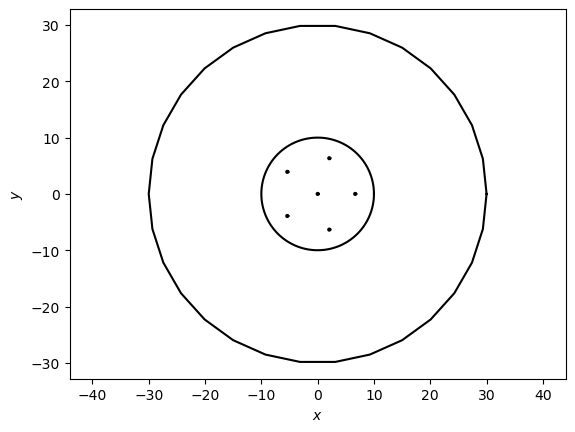

In [13]:
lant.update(0) # set z = 0, lantern entrance
lant.plot_boundaries()

Next, we initialize a `Propagator` object ...

In [14]:
import propagator
prop = propagator.Propagator(wl,lant,6)

Compute the eigenmodes, eigenvalues, and cross-coupling matrices of the waveguide for $z\in $[0,`z_ex`], and save it to `"test_6PL"`. On my machine, the below takes around 25 minutes to run.

generating mesh...
number of mesh points:  5811
initial mesh: 


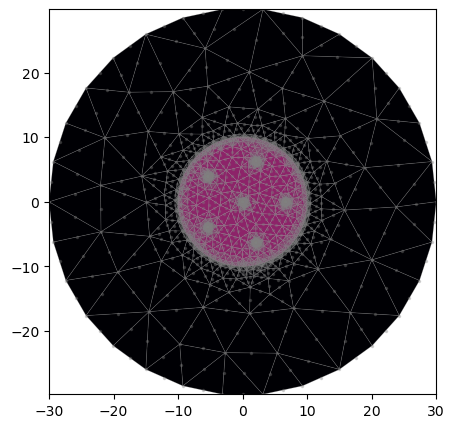

initial modes: 
effective index:  1.4431767725564713


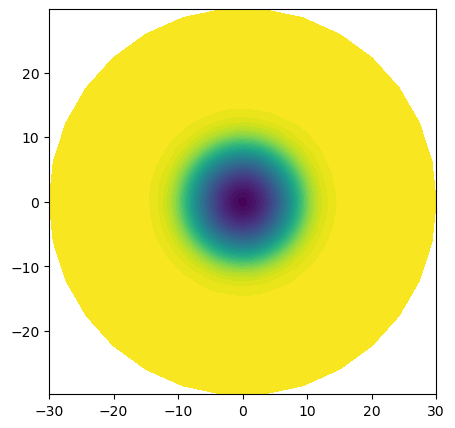

effective index:  1.4419052426368415


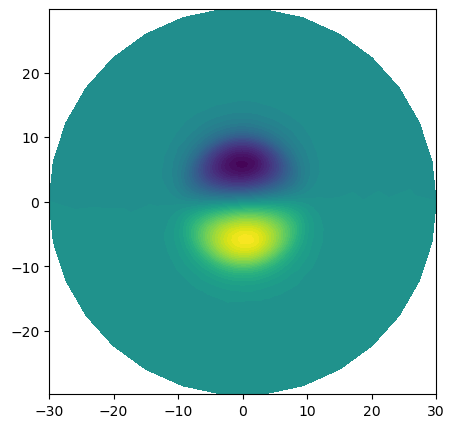

effective index:  1.4419051047284435


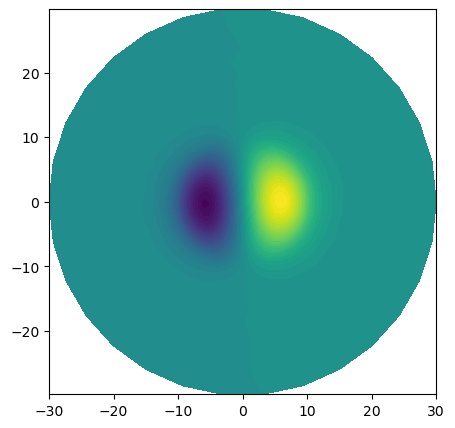

effective index:  1.4402950861909114


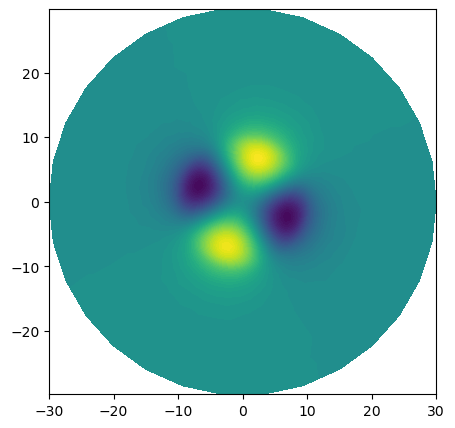

effective index:  1.440295023757147


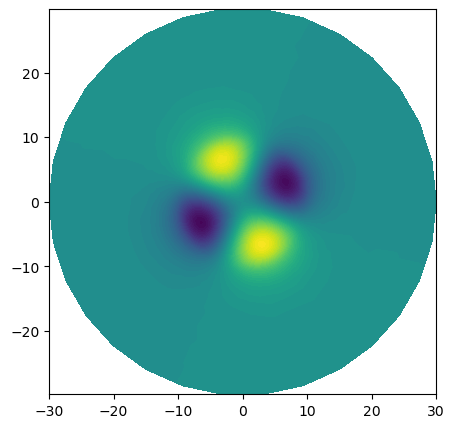

effective index:  1.4398273913653474


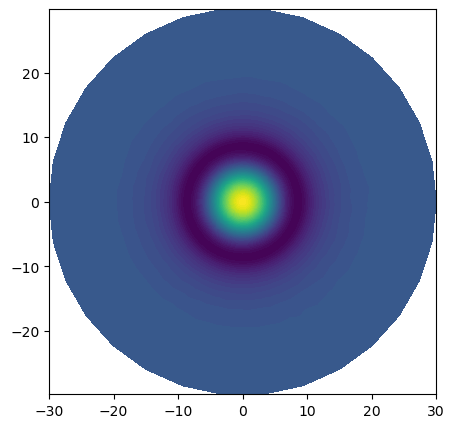

starting computation ...
current z: 19987.5 / 20000 ; current zstep: 12.5         time elapsed:  1424.8650510311127


In [15]:
# this'll take like 25 minutes ...

output = prop.prop_setup(0,z_ex,save=True,tag="test_6PL",plot=True)

# can also load with 
# prop.load(tag="test")

Next, we make the interpolation functions. We can use these interpolation functions to look at the effective index evolution of the eigenmodes through the waveguide.

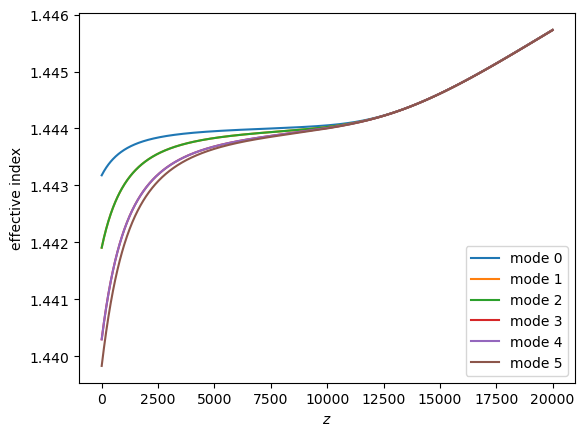

In [ ]:
prop.make_interp_funcs()

zs = np.linspace(0,z_ex,1000)

import matplotlib.pyplot as plt
neffs = prop.compute_neff(zs)
for i in range(6):
    plt.plot(zs,neffs[i],label="mode "+str(i))
plt.xlabel(r"$z$")
plt.ylabel("effective index")
plt.legend(loc='best')
plt.show()

We notice that the modes are initially separated into 4 groups at the lantern entrance (these are ${\rm LP}_{01}$, ${\rm LP}_{11}$, ${\rm LP}_{21}$, and ${\rm LP}_{02}$), while at the lantern exit all modes become degenerate. Let's look at the coupling coefficient matrix next:

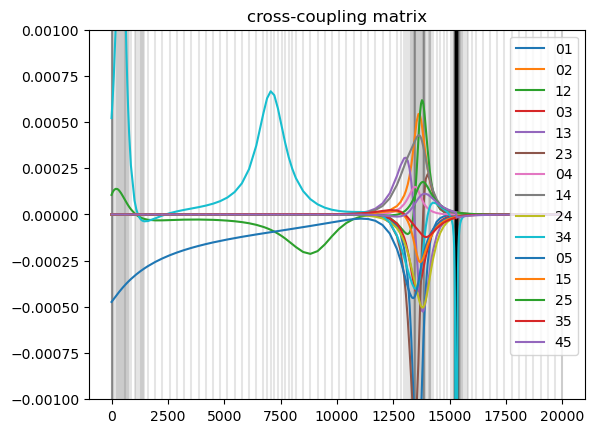

In [17]:
for j in range(6): 
    for i in range(j):
        plt.plot(prop.za,prop.cmat[:,i,j],label=str(i)+str(j))

for z in prop.za: # plot vertical bars at every z value.
    plt.axvline(x=z,alpha=0.1,color='k',zorder=-100)
plt.legend(loc='best')
plt.title("cross-coupling matrix")
plt.ylim(-1e-3,1e-3)
plt.show()

The vertical bars show $z$ locations probed by the adaptive stepping algorithm. Note the huge peak at around $z=15000$! This is due to the degeneracy between modes 3 and 4. These peaks, while they slow down computation, are typically not an issue **if** they are well-resolved by the adaptive stepping scheme.

Finally, let's propagate the ${\rm LP}_{01}$ mode (which has the highest eigenvalue and is therefore the first eigenmode at the waveguide entrance). Due to the rotational symmetry of the lantern, we should expect to find that same symmetry in the lantern outputs if we inject in a rotationally invariant mode like the ${\rm LP}_{01}$ mode. Below we plot the eigenmode amplitudes as a function of $z$.

final mode amplitudes: 
[0.71811305 0.30889218 0.30896356 0.30896182 0.30893762 0.30882921]
final mode powers: 
[0.51568636 0.09541438 0.09545848 0.09545741 0.09544245 0.09537548]


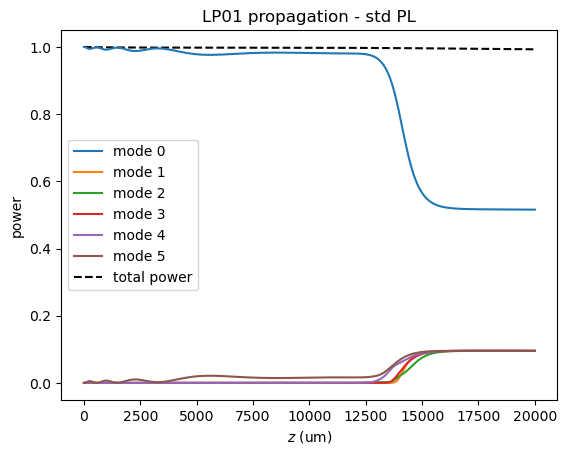

In [ ]:
u0 = [1,0,0,0,0,0] # launch field, LP01

z,u,uf = prop.propagate(u0,z_ex,WKB=True)

print("final mode amplitudes: ")
print(np.abs(uf))
print("final mode powers: ")
print(np.power(np.abs(uf),2))

import matplotlib.pyplot as plt
for i in range(6): # plotting evolution in mode power
    plt.plot(z,np.power(np.abs(u[i]),2),label='mode '+str(i))

plt.plot(z,np.sum(np.power(np.abs(u),2),axis=0),color='k',zorder=-100,label="total power",ls='dashed')
plt.title('LP01 propagation - std PL')

plt.xlabel(r'$z$ (um)')
plt.ylabel("power")

plt.legend(loc='best')
plt.show()

From the above plot, we see that we might have recovered the expected symmetry. However, our result is on the shape and order of the instantaneous eigenmodes at the lantern output (recall that all the eigenmodes are degnerate at the output, so the eigenmodes are not well-defined.) As a sanity check, we can construct the output field manually and gauge the symmetry by eye. We do this below.

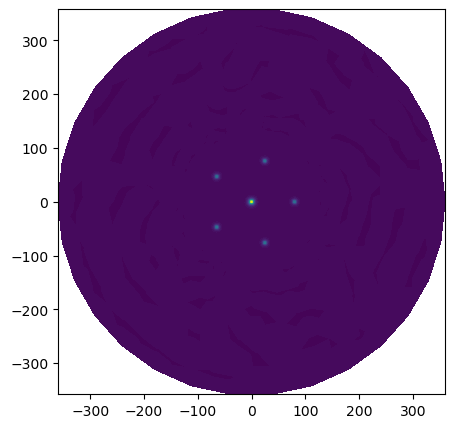

In [ ]:
# uf is the final mode amplitudes
# prop.vs[:,:,-1] is the final eigenbasis

output_field = np.sum(uf[None,:]*prop.vs[:,:,-1],axis=1)
from wavesolve.fe_solver import plot_eigenvector

plot_eigenvector(prop.mesh,np.real(output_field))

Looks good!

<a id='sec5'></a>
## **5. Worked example: directional coupler (dicoupler)** 

### **4.1 Dicoupler review**

The simplest directional coupler is composed of two embedded single-mode channels, which are "squeezed" to some minimum core-to-core separation over a given length, which we will call the "coupling length". Along the coupling length, power between the channels oscillates. If the overall waveguide is symmetric, the net power transfer between the cores can vary from 0 to 1, and will oscillate sinusoidally with the coupling length.

This same behavior can also be viewed using the supermode basis, which is the basis `cbeam` uses. When the two channels are widely separated, the two supermodes of the waveguides are the same as the fundamental modes of each isolated single-mode channel (assuming the supermodes are not degenerate; if they are, you can choose two supermodes such that this is the case). When the two channels are squeezed together, the supermode structure changes: the first supermode is a symmetric combination of the two channel modes, while the second is antisymmetric. Furthermore, even if the two supermodes were originally degenerate, they will develop a slight difference in effective index in the coupling region.

A wavefront originally confined to one channel of a symmetric dicoupler will evenly excite both the symmetric and antisymmetric supermodes. Due to the difference in effective index, the supermodes beat against each other. The net effect is an apparent oscillation in power between the dicoupler channels --- as claimed above. As the coupling length changes, the amount of phase beating changes, which in turn changes the power splitting ratio of the dicoupler.

### **4.2 Simulation**

We will use the pre-made `Dicoupler` class simulate a dicoupler. First, let's define our parameters.

In [1]:
### symmetric dicoupler propagation parameters ###

wl = 1.55                           # wavelength, um
dmin = 10.                          # minimum center-to-center separation of single mode channels
dmax = 60.                          # maximum center-to-center separation of single mode channels
coupling_length = 5000.             # length of coupling region (where SM channels are close)
bend_length = coupling_length/4.   # approximate length of channel bends

rcore = 3.                      # core radius. we will simulate a symmetric dicoupler, so core radii of both channels are the same

nclad = 1.444                   # cladding refractive index
ncore = nclad + 8.8e-3          # SM core refractive index

# mesh params #
core_res = 60                    # no. of line segments to use to resolve the core-cladding interface(s)
clad_mesh_size = 10.0               # mesh size (triangle side length) to use in the cladding region
core_mesh_size = 0.5                # mesh size (triangle side length) to use inside the cores

Note that for the `Dicoupler` class, we specify a coupling length, not the overall waveguide length. The overall waveguide length is auto-computed (in this basic implementation, it's two times the coupling length) and can be accessed through `Dicoupler.z_ex`. 
Let's make the dicoupler and inspect the paths. I've made a built-in plotting function for this.

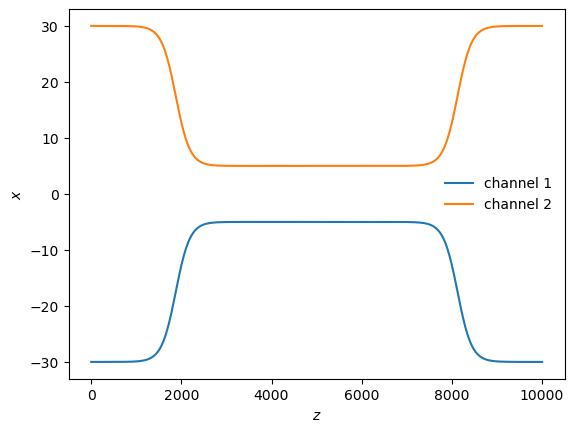

In [2]:
import waveguide

dicoupler = waveguide.Dicoupler(rcore,rcore,ncore,ncore,dmax,dmin,nclad,coupling_length,bend_length,core_res,core_mesh_size=core_mesh_size,clad_mesh_size=clad_mesh_size)

# here we could adjust the boundary refinement mesh parameters, e.g.
# dicoupler.min_mesh_size = <minimum mesh element size>
# here, I'll set mesh_dist_scale lower to increase the mesh resolution around the core boundaries.

dicoupler.mesh_dist_scale = 0.5

dicoupler.plot_paths()

Next, we'll initialize the propagator.

In [6]:
import propagator
adprop = propagator.Propagator(wl,dicoupler,Nmax=2)


Next we'll run the setup and save the output to `"test_dicoupler"`. This takes around 11 minutes on my machine.

generating mesh...
number of mesh points:  4441
initial mesh: 


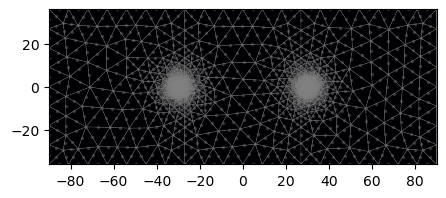

initial modes: 
effective index:  1.4474931875706372


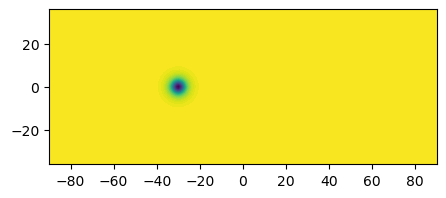

effective index:  1.447493187343356


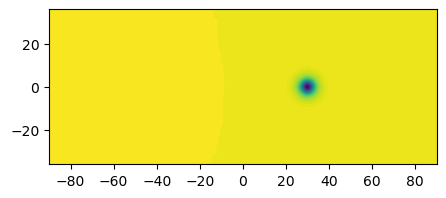

starting computation ...
current z: 9990.0 / 10000.0 ; current zstep: 10.0         time elapsed:  617.7479934692383


In [7]:
# note that here we could also adjust z-stepping params, e.g.
# adprop.zstep_tol = <adaptive stepping tolerance>, or
# adprop.min_zstep = <minimum z step>

adprop.zstep_tol = 5e-5 # For this example, I need to make the tolerance tighter

output = adprop.prop_setup(0,dicoupler.z_ex,save=True,tag="test_dicoupler",plot=True)

Now, let's propagate, and plot the mode amplitudes as a function of $z$. I'm using a very coarse simulation resolution here to speed things up. We'll inject into the "left" channel. 

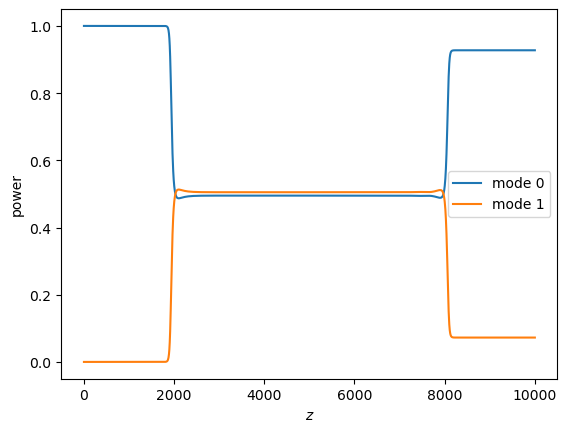

In [8]:
import matplotlib.pyplot as plt
import numpy as np

adprop.make_interp_funcs()

u0 = np.array([1,0],dtype=np.complex128)
z,u,uf = adprop.propagate(u0,dicoupler.z_ex)

plt.plot(z,np.power(np.abs(u[0]),2),label="mode 0")
plt.plot(z,np.power(np.abs(u[1]),2),label="mode 1")
plt.xlabel(r"$z$")
plt.ylabel("power")
plt.legend(loc="best")
plt.show()

We see that upon entering the coupling region, $z\in[2500,7500]$, the amplitude of mode 0 falls and the amplitude of mode 1 rises until both are $\sim 0.5$. This is telling us that the injection of light into a single channel is evenly exciting both supermodes in the coupling region. Upon leaving the cross-coupling region, the mode amplitudes split. The split ratio depends on the coupling length, as we will see later.

For fun, let's also plot the cross-coupling matrix.

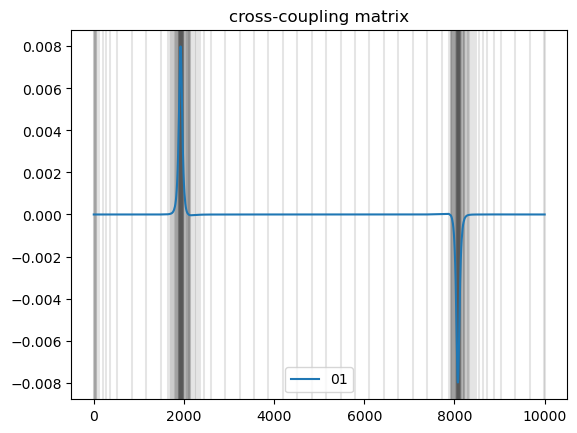

In [9]:
for j in range(2): 
    for i in range(j):
        plt.plot(adprop.za,adprop.cmat[:,i,j],label=str(i)+str(j))

for z in adprop.za: # plot vertical bars at every z value.
    plt.axvline(x=z,alpha=0.1,color='k',zorder=-100)
plt.legend(loc='best')
plt.title("cross-coupling matrix")
plt.show()

We can quickly look at the effect that the coupling length has on the final output powers of the dicoupler by playing some tricks. The `prop_setup()` function returns the eigenmodes, eigenvalues, and cross-coupling matrix over some array of $z$ values. Supposing that everything is well-sampled, we can apply a transformation of our choice to the $z$ array (so long as that transformation preserves monotonicity). In doing so, we are simulating a longitudinal re-scaling of the waveguide structure, while avoiding the need to rerun `prop_setup()`.

I provide an example below. We are interested in the oscillation period of the output powers of the dicoupler as a function of coupling length, for which there are empirical expressions (see the section after this one). The transformation I will apply is to simply split the $z$ array in half, displacing the latter half by some positive amount. 

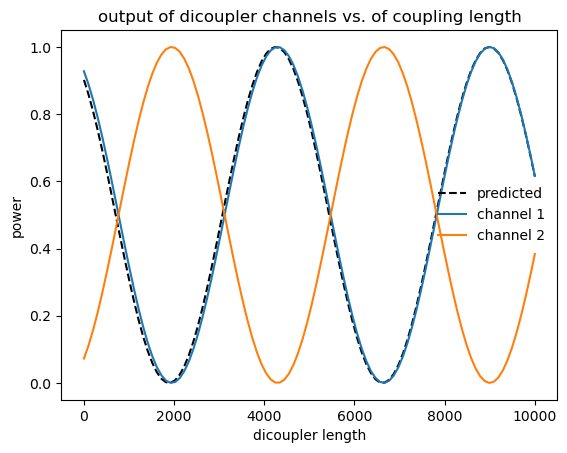

In [10]:
stretch_amounts = np.linspace(0,10000,100)
u0 = np.array([1,0],dtype=np.complex128)
pwrs = []

for i,stretch in enumerate(stretch_amounts):
    za = np.copy(adprop.za)
    za[np.argmax(za>=dicoupler.z_ex/2):] += stretch # stretch out the z array

    adprop.make_interp_funcs(za) # remake the interpolation functions
    z,u,uf = adprop.propagate(u0,za[-1]) # rerun the propagator
    
    pwr = np.power(np.abs(uf),2) 
    pwrs.append(pwr)

pwrs = np.array(pwrs)

pred_period = 4735.127278529681 ## SEE BELOW ##

zmax = stretch_amounts[np.argmax(pwrs[:,0])] # translating the sinusoid to match
plt.plot(stretch_amounts,np.power(np.cos(np.pi/pred_period*(stretch_amounts-zmax)),2),color='k',ls='dashed',label="predicted")

plt.plot(stretch_amounts,pwrs.T[0],label="channel 1")
plt.plot(stretch_amounts,pwrs.T[1],label="channel 2")
plt.legend(loc='best',frameon=False)
plt.xlabel("dicoupler length")
plt.ylabel("power")
plt.title("output of dicoupler channels vs. of coupling length")
plt.show()


In the above plot, I also show a "predicted" power output as a function of length. The derivation can be found in fiber optics textbooks. For an ideal, symmetric dicoupler with light injected solely into channel 1, the output power in channel 1 is 

$$
P_1 = \cos^2(\kappa L)
$$

The oscillation wavenumber $\kappa$ has an useful empirical approximation [1]:

$$
\kappa \approx \dfrac{\pi V}{2 k n_{\rm clad} r^2} \exp\left[ -\left(c_0 +c1\frac{d}{a}+c_2\frac{d^2}{a^2} \right) \right]
$$

for $k$ the free-space wavenumber, $r$ the single-mode channel core radius, $d$ the inter-core spacing at minimum separation, and $n_{\rm clad}$ the refractive indexing of the cladding. The fiber $V$ number is defined as 

$$
V = kr\sqrt{n_{\rm core}^2-n_{\rm clad}^2}
$$

where $n_{\rm core}$ is the refractive index of the core material. The empirical constants are defined through:

$$
c_0 = 5.2789 - 3.663 V + 0.3841 V^2
$$

$$
c_1 = -0.7769 + 1.2252 V - 0.0152 V^2
$$

$$
c_2 = −0.0175 − 0.0064 V + 0.0009V^2
$$

For our dicoupler parameters, the predicted period is $\sim 4735$ $\mu {\rm m}$.

*An aside...*

While the oscillation period of our simulated dicoupler matches the theory, the oscillation is not in phase with what is predicted by the theory. I think this is because the theoretical analysis assumes fixed inter-core spacing and neglects the transitioning regions of the dicoupler. Neither of those are true with our model, which assumes $\tanh(z)$ variation for the inter-core spacing and includes the dicoupler bends.


**References**

[1] R. Tewari and K. Thyagarajan, "Analysis of tunable single-mode fiber directional couplers using simple and accurate relations," in Journal of Lightwave Technology, vol. 4, no. 4, pp. 386-390, April 1986, doi: 10.1109/JLT.1986.1074731